In [88]:
import pandas as pd
import quandl
import math
import datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
df = quandl.get("WIKI/GOOGL")

In [89]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [90]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [91]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close'])/df['Adj. Close']*100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open'])/df['Adj. Open']*100
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0


In [92]:
forecast_col = 'Adj. Close'
df.fillna(-99999,inplace = True)
forecast_out = int(math.ceil(0.01*len(df))) #Predicting 10% of the len of the dataset, i.e in terms of duration
df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True)
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,69.078238
2004-08-20,54.322689,0.710922,7.227007,22834300.0,67.839414
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,1.886792,1.183658,9188600.0,71.219849


In [93]:
X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
y = np.array(df['label'])

len(X),len(y)

(3389, 3389)

In [94]:
X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,y,test_size=0.2)
clf = svm.SVR()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test,y_test)
print("Accuracy =",accuracy*100,"%")

Accuracy = 80.3242491086 %


In [100]:
clf = LinearRegression()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test,y_test)
forecast_set = clf.predict(X_lately)
df['forecast'] =np.nan
print(forecast_set,accuracy*100,forecast_out)

[ 1077.7287146   1092.34982046  1106.28399195  1100.92431498  1094.45727806
  1091.8121777   1090.18699201  1087.15226293  1081.01511443  1076.65082488
  1074.30819142  1093.82107382  1112.24925668  1116.75529704  1131.64153077
  1135.66092485  1134.31190407  1131.79364141  1133.58497617  1151.99516926
  1151.26375944  1161.19500948  1157.79435465  1165.5526909   1185.87914966
  1198.27405553  1192.63703483  1204.50636012  1210.06491621  1208.18888877
  1198.9391966   1204.4692142   1203.14250243  1138.79082335  1085.82208589] 97.9535720951 35


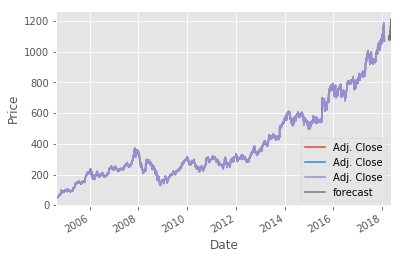

In [101]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 84600
next_unix = last_unix+one_day
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
df['Adj. Close'].plot()
df['forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()